## This notebook presents the reproducible procedure that we followed in comparing the performance of Hybrid Quantum-Classical Neural Networks and Classical Convolutional Neural Networks on the MESSIDOR dataset. The MESSIDOR dataset is a diabetic-retinopathy dataset with 1544 fundus images. The dataset was produced in France and is labeled with five-category classification (no diabetic retinopathy, mild diabetic retinopathy, moderate diabetic retinopathy, severe diabetic retinopathy, and proliferative diabetic retinopathy).

### Installing and Importing Dependencies

In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 98.6 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from google.colab import drive
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Sampler
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import time
import os
import copy
from torch.optim.lr_scheduler import CosineAnnealingLR
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve,
    precision_recall_curve, auc
)
from sklearn.preprocessing import label_binarize
import random


os.environ["OMP_NUM_THREADS"] = "1"

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/Resnet-18-MESSIDOR_models/"

### General Training, Validation, Testing Functions

In [ ]:
import torchvision
from torchvision import datasets, transforms

In [ ]:
def train_model(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_probs = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        probs = torch.softmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())



    avg_train_loss = train_loss / len(train_loader.dataset)
    accuracy = correct / total * 100

    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_train_loss, accuracy, avg_auroc

In [ ]:
def validate_model(model, valid_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            probs = torch.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader.dataset)
    accuracy = correct / total * 100
    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_val_loss, accuracy, avg_auroc

In [ ]:
import pickle

def train_validate_model(n_epochs, model, model_name, train_loader, valid_loader, seed):

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

  def adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max):
        if epoch < lr_warmup_epochs:
            lr = lr_max * (epoch + 1) / lr_warmup_epochs
        else:
            lr = lr_max
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

  scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs - 10, eta_min=1e-6)

  best_val_loss = float('inf')
  best_model_weights = model.state_dict()
  epochs_without_improvement = 0
  early_stopping_patience = 10

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []
  train_aucs = []
  val_aucs = []

  lr_max = 5e-4
  lr_warmup_epochs = 10

  for epoch in range(n_epochs):
      print(f'Epoch [{epoch+1}/{n_epochs}]')

      adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max)

      train_loss, train_accuracy, train_auroc = train_model(model, train_loader, optimizer, criterion)
      val_loss, val_accuracy, val_auroc = validate_model(model, valid_loader, criterion)


      print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Training AUROC: {train_auroc:.4f}')
      print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation AUROC: {val_auroc:.4f}')
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)
      train_aucs.append(train_auroc)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)
      val_aucs.append(val_auroc)

      if epoch >= lr_warmup_epochs:
            scheduler.step()

      if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()
            epochs_without_improvement = 0  # Reset counter

      else:
            epochs_without_improvement += 1

      if epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

  model.load_state_dict(best_model_weights)
  torch.save(model, os.path.join(MODEL_SAVE_PATH, f'{model_name}_{seed}.pth'))

  metrics = {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "train_aucs": train_aucs,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "val_aucs": val_aucs
    }

  with open(os.path.join(MODEL_SAVE_PATH, f'{model_name}_{seed}_metrics.pkl'), 'wb') as f:
        pickle.dump(metrics, f)


  return model, train_losses, train_accuracies, val_losses, val_accuracies, train_aucs, val_aucs

In [ ]:
import math
import matplotlib.pyplot as plt

def plot(quantum_loss, normal_loss, quantum_acc, normal_acc, quantum_auc, normal_auc):
    plt.style.use("default")

    loss_min = math.floor(min(min(quantum_loss), min(normal_loss)) * 10) / 10
    loss_max = math.ceil(max(max(quantum_loss), max(normal_loss)) * 10) / 10

    acc_min = math.floor(min(min(quantum_acc), min(normal_acc)) * 10) / 10
    acc_max = math.ceil(max(max(quantum_acc), max(normal_acc)) * 10) / 10

    auc_min = math.floor(min(min(quantum_auc), min(normal_auc)) * 10) / 10
    auc_max = math.ceil(max(max(quantum_auc), max(normal_auc)) * 10) / 10

    plt.figure(figsize=(6, 3))
    plt.plot(quantum_loss, label="With quantum layer")
    plt.plot(normal_loss, label="Without quantum layer")
    plt.ylabel("Loss")
    plt.ylim([loss_min, loss_max])
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Loss vs. Epoch")
    plt.show()

    plt.figure(figsize=(6, 3))
    plt.plot(quantum_acc, label="With quantum layer")
    plt.plot(normal_acc, label="Without quantum layer")
    plt.ylabel("Accuracy")
    plt.ylim([acc_min, acc_max])
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Accuracy vs. Epoch")
    plt.show()

    plt.figure(figsize=(6, 3))
    plt.plot(quantum_auc, label="With quantum layer")
    plt.plot(normal_auc, label="Without quantum layer")
    plt.ylabel("ROCAUC")
    plt.ylim([auc_min, auc_max])
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("ROCAUC vs. Epoch")
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.preprocessing import label_binarize
from itertools import cycle


def test(model_hybrid, model_normal, test_loader, num_classes):
    model_hybrid.eval()
    model_normal.eval()

    all_labels = []
    all_preds_hybrid = []
    all_preds_normal = []
    all_probs_hybrid = []
    all_probs_normal = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)


            outputs_hybrid = model_hybrid(images)
            _, preds_hybrid = torch.max(outputs_hybrid, 1)
            probs_hybrid = torch.softmax(outputs_hybrid, dim=1)
            # Normal model predictions
            outputs_normal = model_normal(images)
            _, preds_normal = torch.max(outputs_normal, 1)
            probs_normal = torch.softmax(outputs_normal, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds_hybrid.extend(preds_hybrid.cpu().numpy())
            all_preds_normal.extend(preds_normal.cpu().numpy())
            all_probs_hybrid.extend(probs_hybrid.cpu().numpy())
            all_probs_normal.extend(probs_normal.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds_hybrid = np.array(all_preds_hybrid)
    all_preds_normal = np.array(all_preds_normal)
    all_probs_hybrid = np.array(all_probs_hybrid)
    all_probs_normal = np.array(all_probs_normal)


    accuracy_hybrid = accuracy_score(all_labels, all_preds_hybrid)
    accuracy_normal = accuracy_score(all_labels, all_preds_normal)


    f1_hybrid = f1_score(all_labels, all_preds_hybrid, average='weighted')
    f1_normal = f1_score(all_labels, all_preds_normal, average='weighted')


    if num_classes == 2:
        precision_hybrid = precision_score(all_labels, all_preds_hybrid, pos_label=1)
        recall_hybrid = recall_score(all_labels, all_preds_hybrid, pos_label=1)
        precision_normal = precision_score(all_labels, all_preds_normal, pos_label=1)
        recall_normal = recall_score(all_labels, all_preds_normal, pos_label=1)
    else:
        precision_hybrid = precision_score(all_labels, all_preds_hybrid, average='weighted')
        recall_hybrid = recall_score(all_labels, all_preds_hybrid, average='weighted')
        precision_normal = precision_score(all_labels, all_preds_normal, average='weighted')
        recall_normal = recall_score(all_labels, all_preds_normal, average='weighted')


    hybrid_aucs = []
    normal_aucs = []

    if num_classes == 2:

        all_probs_hybrid_class1 = all_probs_hybrid[:, 1]
        all_probs_normal_class1 = all_probs_normal[:, 1]

        auc_hybrid = roc_auc_score(all_labels, all_probs_hybrid_class1)
        auc_normal = roc_auc_score(all_labels, all_probs_normal_class1)

        print(f'Hybrid Model AUROC: {auc_hybrid:.4f}')
        print(f'Normal Model AUROC: {auc_normal:.4f}')

        fpr_hybrid, tpr_hybrid, _ = roc_curve(all_labels, all_probs_hybrid_class1)
        plt.figure(figsize=(10, 6))
        plt.plot(fpr_hybrid, tpr_hybrid, label=f'Hybrid Model AUROC = {auc_hybrid:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('ROC Curve - Hybrid Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

        # Plot ROC curve for the Normal Model
        fpr_normal, tpr_normal, _ = roc_curve(all_labels, all_probs_normal_class1)
        plt.figure(figsize=(10, 6))
        plt.plot(fpr_normal, tpr_normal, label=f'Normal Model AUROC = {auc_normal:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('ROC Curve - Normal Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

    else:  # Multi-class Classification

        all_labels_binarized = label_binarize(all_labels, classes=np.arange(num_classes))

        # Define a color cycle for plotting
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
        # Plot ROC curves for the Hybrid Model
        plt.figure(figsize=(10, 8))
        for i, color in zip(range(num_classes), colors):
            fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_probs_hybrid[:, i])
            roc_auc = auc(fpr, tpr)
            hybrid_aucs.append(roc_auc)
            plt.plot(fpr, tpr, color=color, lw=2,
                    label=f'Class {i} (AUC = {roc_auc:.2f})')


        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves - Hybrid Model')
        plt.legend(loc='lower right')
        plt.show()

        # Plot ROC curves for the Normal Model
        plt.figure(figsize=(10, 8))
        for i, color in zip(range(num_classes), colors):
            fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_probs_normal[:, i])
            roc_auc = auc(fpr, tpr)
            normal_aucs.append(roc_auc)
            plt.plot(fpr, tpr, color=color, lw=2,
                    label=f'Class {i} (AUC = {roc_auc:.2f})')


        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves - Normal Model')
        plt.legend(loc='lower right')
        plt.show()



    normal_auc = f"{sum(normal_aucs) / len(normal_aucs):.4f}"
    hybrid_auc = f"{sum(hybrid_aucs) / len(hybrid_aucs):.4f}"

    print("\nHybrid Model Metrics:")
    print(f'Accuracy: {accuracy_hybrid:.4f}')
    print(f'F1 Score: {f1_hybrid:.4f}')
    print(f'Precision: {precision_hybrid:.4f}')
    print(f'Recall: {recall_hybrid:.4f}')
    print(f'AUROC: {hybrid_auc}')

    print("\nNormal Model Metrics:")
    print(f'Accuracy: {accuracy_normal:.4f}')
    print(f'F1 Score: {f1_normal:.4f}')
    print(f'Precision: {precision_normal:.4f}')
    print(f'Recall: {recall_normal:.4f}')
    print(f'AUROC: {normal_auc} \n')

    cm_hybrid = confusion_matrix(all_labels, all_preds_hybrid)


    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: Hybrid Model (Avg AUC = {hybrid_auc})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    cm_normal = confusion_matrix(all_labels, all_preds_normal)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_normal, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: Classical Model (Avg AUC = {normal_auc})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
def load_data(batch_size, dataset):

  train_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  valid_test_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])


  if dataset == 'APTOS':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS2019/"

  elif dataset == "IDRID":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_images/"

  elif dataset == "Messidor":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR2/"

  elif dataset == "GlaucomaFundus":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/Glaucoma_fundus/"

  elif dataset == "PAPILA":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/PAPILA/"

  elif dataset == 'G1020':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/G1020/"


  train_dataset = datasets.ImageFolder(root=data_dir + 'train', transform=train_transform)
  val_dataset = datasets.ImageFolder(root=data_dir + 'val', transform=valid_test_transform)
  test_dataset = datasets.ImageFolder(root=data_dir + 'test', transform=valid_test_transform)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
  valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

  return train_loader, valid_loader, test_loader

### Classical CNN Model Construction and General Methods

In [ ]:
class NormalModel(nn.Module):
  def __init__(self, freeze, num_classes, device='cuda'):
        super(NormalModel, self).__init__()

        weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        self.model = torchvision.models.resnet18(weights=weights)

        if freeze:
          for param in self.model.parameters():
              param.requires_grad = False

        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.model = self.model.to(device)

  def forward(self, x):
        return self.model(x)

### Hybrid Quantum-Classical Resnet-18 Construction

In [ ]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [ ]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    for i in range(0, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])

In [ ]:
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
@qml.qnode(dev)
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [ ]:
class DressedQuantumNet(nn.Module):

    def __init__(self, q_depth, num_classes):

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, num_classes)

    def forward(self, input_features):


        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [ ]:
class QuantumHybridModel(nn.Module):
  def __init__(self, q_depth, freeze, num_classes, device='cuda'):
        super(QuantumHybridModel, self).__init__()

        weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        self.model = torchvision.models.resnet18(weights=weights)

        if freeze:
          for param in self.model.parameters():
              param.requires_grad = False

        self.model.fc = DressedQuantumNet(q_depth, num_classes)

        self.model = self.model.to(device)

  def forward(self, x):
        return self.model(x)

# Experiments

In [ ]:
n_epochs = 100
num_classes = 5
batch_size = 32
dataset = "Messidor"
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'
q_depth = 4

## Seed Experiment 1

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=5)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Experiment with Seed 80:


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 204MB/s]


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.4388, Training Accuracy: 44.65%, Training AUROC: 0.4289
Validation Loss: 1.3046, Validation Accuracy: 56.50%, Validation AUROC: 0.4581
Epoch [2/100]
Training Loss: 1.2291, Training Accuracy: 57.61%, Training AUROC: 0.4441
Validation Loss: 1.1897, Validation Accuracy: 58.13%, Validation AUROC: 0.5013
Epoch [3/100]
Training Loss: 1.1669, Training Accuracy: 58.23%, Training AUROC: 0.4800
Validation Loss: 1.1621, Validation Accuracy: 58.54%, Validation AUROC: 0.5329
Epoch [4/100]
Training Loss: 1.1366, Training Accuracy: 58.44%, Training AUROC: 0.5255
Validation Loss: 1.1384, Validation Accuracy: 58.54%, Validation AUROC: 0.5690
Epoch [5/100]
Training Loss: 1.1039, Training Accuracy: 58.44%, Training AUROC: 0.5910
Validation Loss: 1.1176, Validation Accuracy: 58.54%, Validation AUROC: 0.5994
Epoch [6/100]
Training Loss: 1.0804, Training Accuracy: 59.05%, Training AUROC: 0.6245
Validation Loss: 1.1019, Validation Accuracy: 58.94%, Validation AUROC: 0.6293
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.4986, Training Accuracy: 26.75%, Training AUROC: 0.5005
Validation Loss: 1.4278, Validation Accuracy: 49.59%, Validation AUROC: 0.5250
Epoch [2/100]
Training Loss: 1.3898, Training Accuracy: 55.56%, Training AUROC: 0.5269
Validation Loss: 1.3687, Validation Accuracy: 58.13%, Validation AUROC: 0.5282
Epoch [3/100]
Training Loss: 1.3481, Training Accuracy: 58.02%, Training AUROC: 0.5511
Validation Loss: 1.3493, Validation Accuracy: 58.54%, Validation AUROC: 0.5140
Epoch [4/100]
Training Loss: 1.3279, Training Accuracy: 58.23%, Training AUROC: 0.5687
Validation Loss: 1.3306, Validation Accuracy: 58.54%, Validation AUROC: 0.5103
Epoch [5/100]
Training Loss: 1.3089, Training Accuracy: 58.44%, Training AUROC: 0.5659
Validation Loss: 1.3150, Validation Accuracy: 58.94%, Validation AUROC: 0.5079
Epoch [6/100]
Training Loss: 1.2904, Training Accuracy: 58.33%, Training AUROC: 0.5600
Validation Loss: 1.2963, Validation Accuracy: 58.94%, Validation AUROC: 0.5094
Epoc

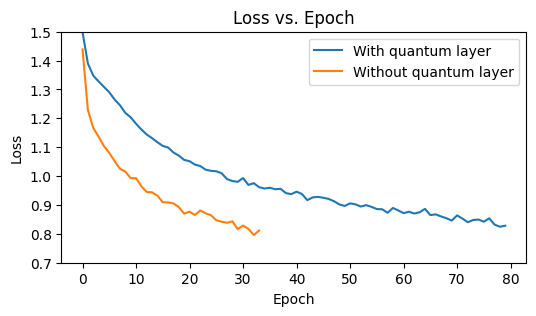

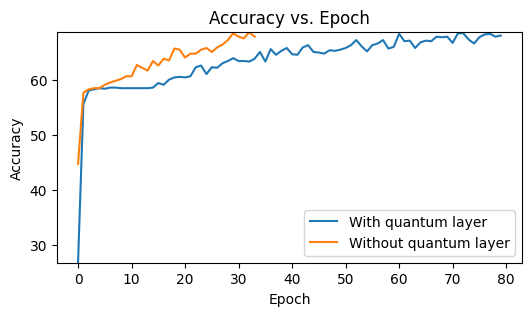

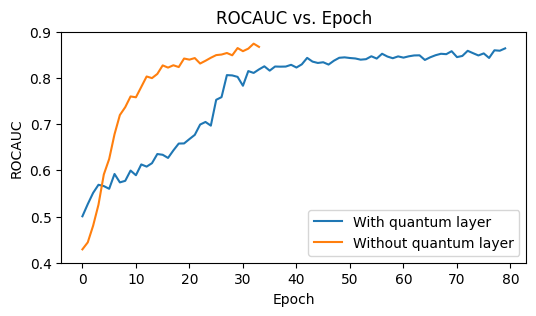

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

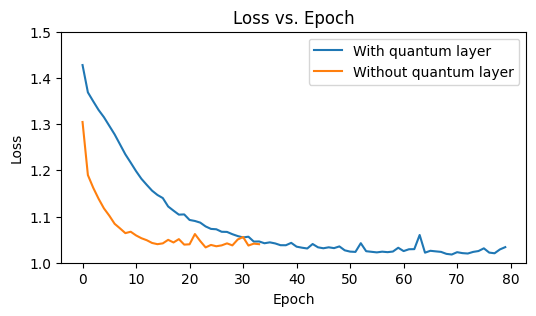

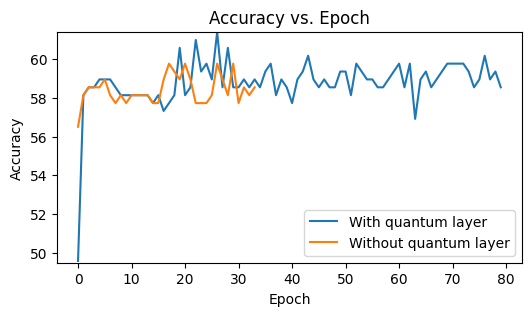

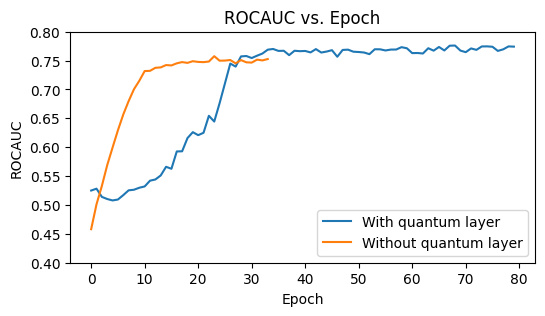

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


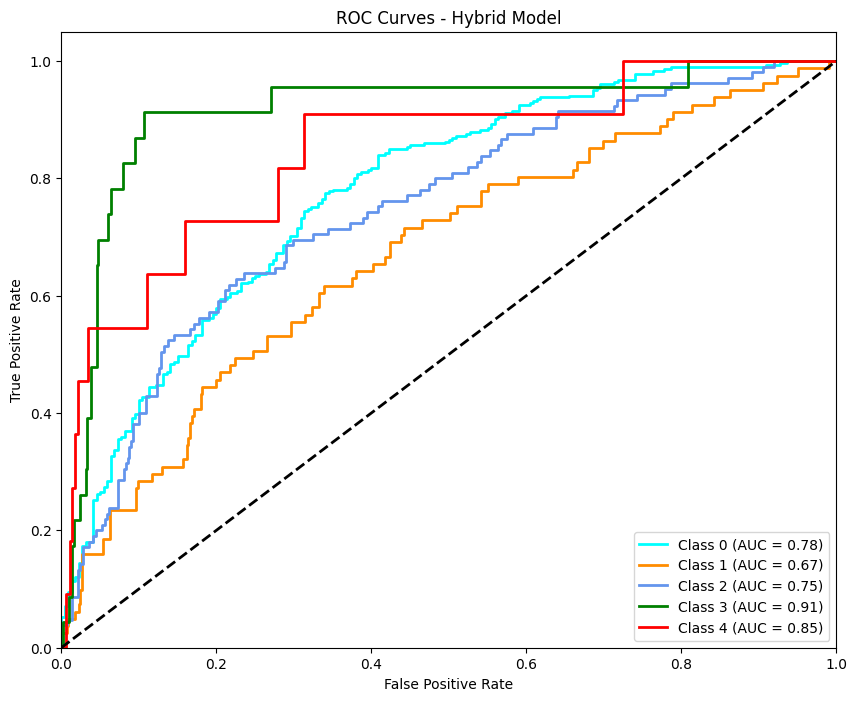

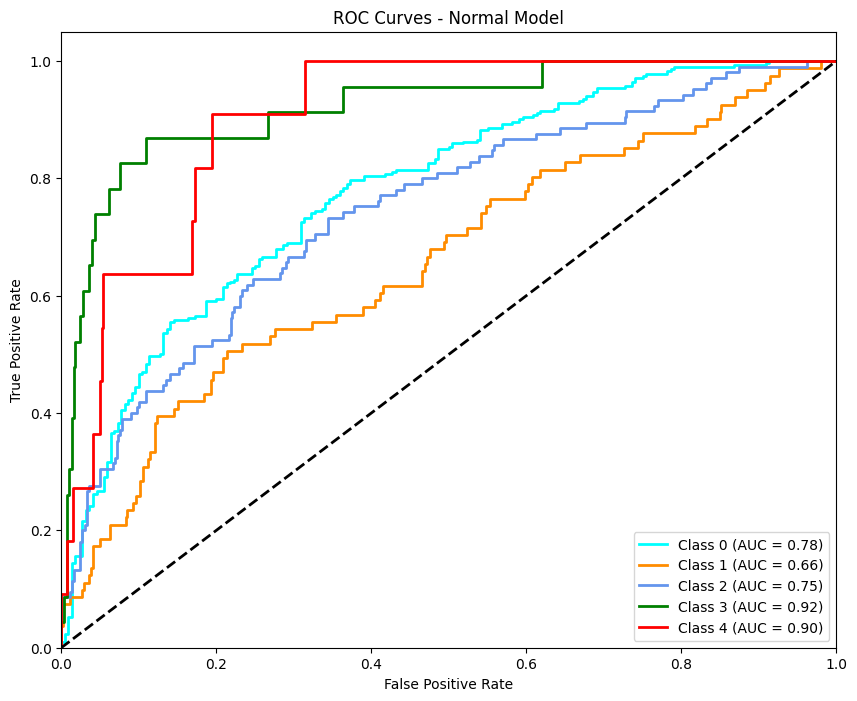


Hybrid Model Metrics:
Accuracy: 0.6198
F1 Score: 0.5532
Precision: 0.5034
Recall: 0.6198
AUROC: 0.7915

Normal Model Metrics:
Accuracy: 0.6350
F1 Score: 0.5787
Precision: 0.5977
Recall: 0.6350
AUROC: 0.8017 



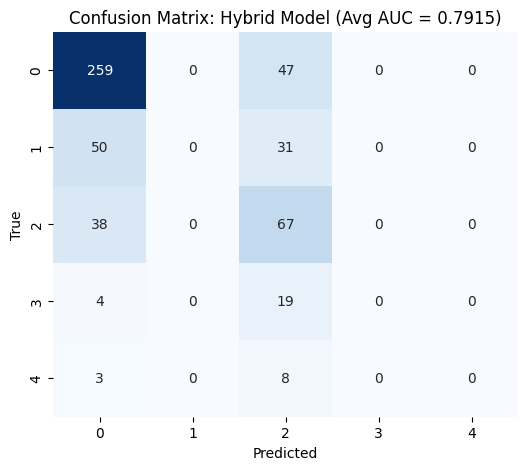

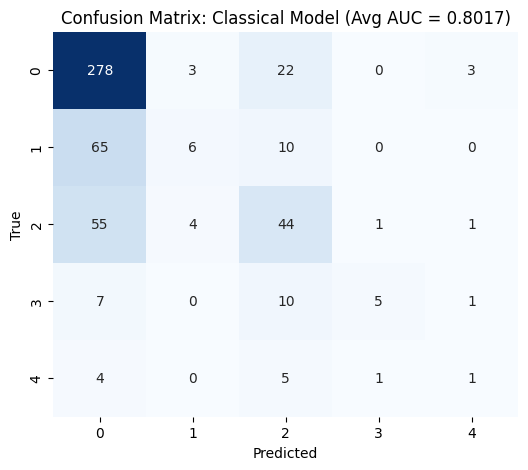

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 2

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=5)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Experiment with Seed 35:


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.6868, Training Accuracy: 22.22%, Training AUROC: 0.5051
Validation Loss: 1.4979, Validation Accuracy: 35.37%, Validation AUROC: 0.4429
Epoch [2/100]
Training Loss: 1.2513, Training Accuracy: 56.28%, Training AUROC: 0.5155
Validation Loss: 1.2023, Validation Accuracy: 57.32%, Validation AUROC: 0.4973
Epoch [3/100]
Training Loss: 1.1492, Training Accuracy: 58.54%, Training AUROC: 0.5371
Validation Loss: 1.1617, Validation Accuracy: 56.50%, Validation AUROC: 0.5303
Epoch [4/100]
Training Loss: 1.1225, Training Accuracy: 58.95%, Training AUROC: 0.5511
Validation Loss: 1.1396, Validation Accuracy: 56.91%, Validation AUROC: 0.5590
Epoch [5/100]
Training Loss: 1.0952, Training Accuracy: 58.95%, Training AUROC: 0.6074
Validation Loss: 1.1236, Validation Accuracy: 56.50%, Validation AUROC: 0.5897
Epoch [6/100]
Training Loss: 1.0782, Training Accuracy: 59.47%, Training AUROC: 0.6393
Validation Loss: 1.1108, Validation Accuracy: 57.72%, Validation AUROC: 0.6220
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.7839, Training Accuracy: 7.92%, Training AUROC: 0.5096
Validation Loss: 1.6126, Validation Accuracy: 22.76%, Validation AUROC: 0.5559
Epoch [2/100]
Training Loss: 1.5358, Training Accuracy: 44.55%, Training AUROC: 0.5144
Validation Loss: 1.4724, Validation Accuracy: 57.72%, Validation AUROC: 0.5996
Epoch [3/100]
Training Loss: 1.4638, Training Accuracy: 58.33%, Training AUROC: 0.5358
Validation Loss: 1.4491, Validation Accuracy: 58.13%, Validation AUROC: 0.6054
Epoch [4/100]
Training Loss: 1.4402, Training Accuracy: 58.44%, Training AUROC: 0.5513
Validation Loss: 1.4291, Validation Accuracy: 58.13%, Validation AUROC: 0.6054
Epoch [5/100]
Training Loss: 1.4184, Training Accuracy: 58.44%, Training AUROC: 0.5068
Validation Loss: 1.4069, Validation Accuracy: 58.13%, Validation AUROC: 0.6058
Epoch [6/100]
Training Loss: 1.3947, Training Accuracy: 58.44%, Training AUROC: 0.5159
Validation Loss: 1.3835, Validation Accuracy: 58.13%, Validation AUROC: 0.6198
Epoch

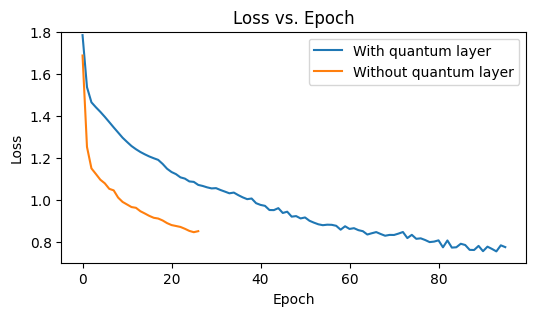

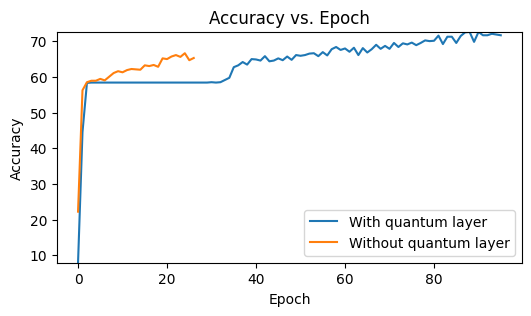

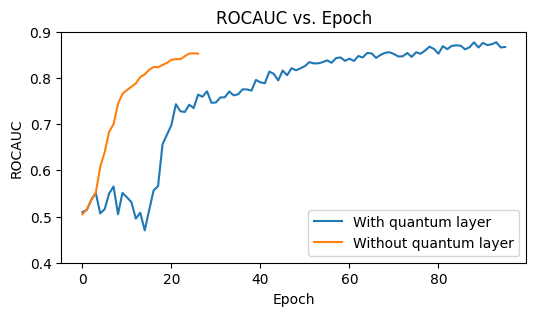

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

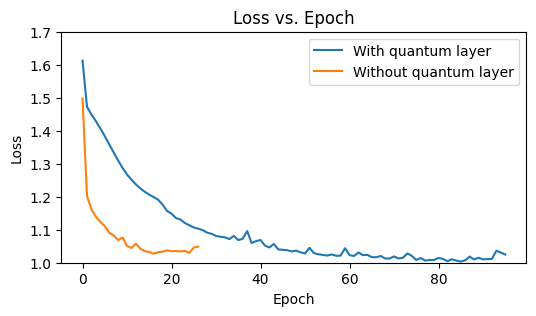

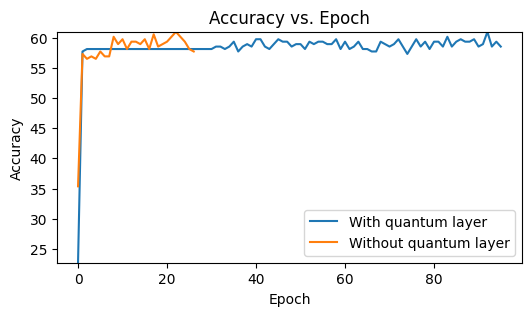

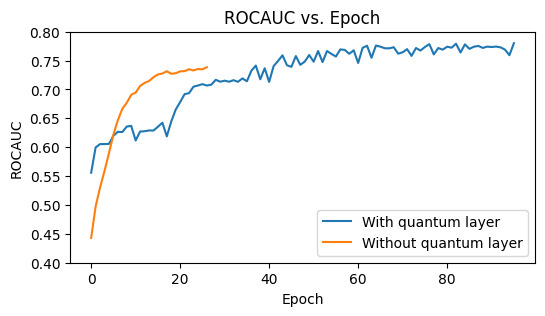

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

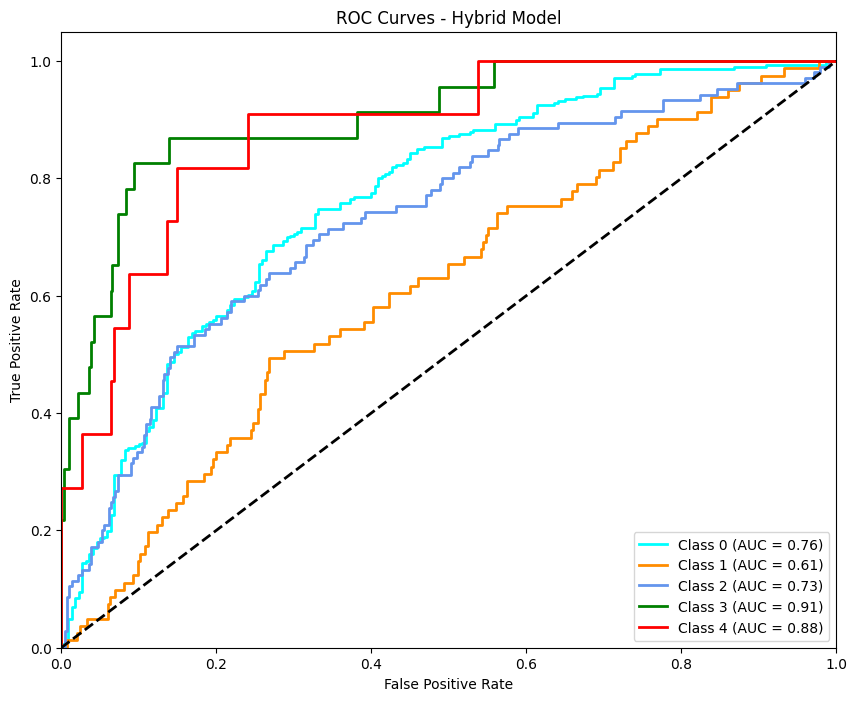

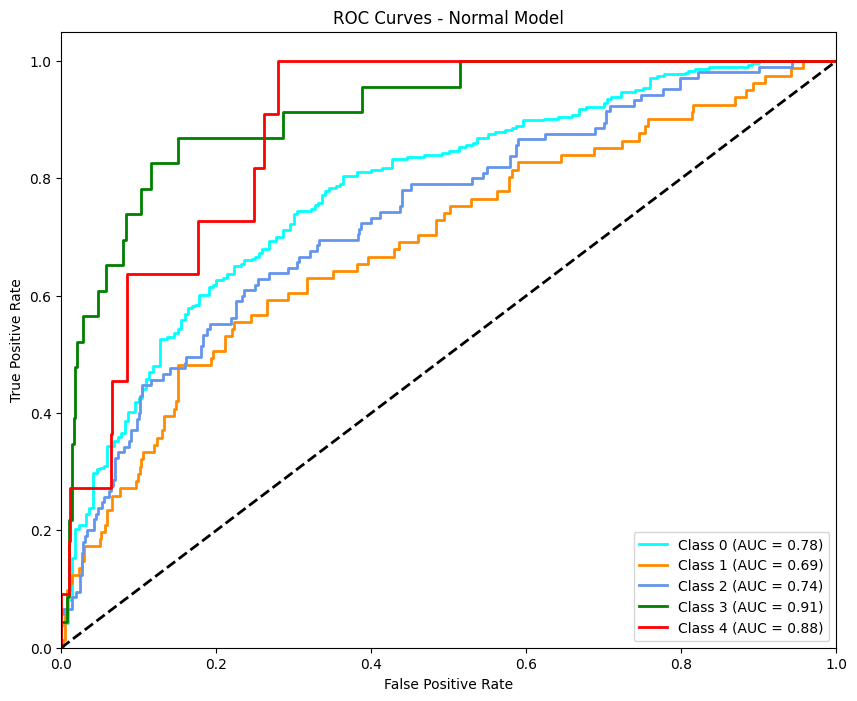


Hybrid Model Metrics:
Accuracy: 0.6331
F1 Score: 0.5720
Precision: 0.5267
Recall: 0.6331
AUROC: 0.7788

Normal Model Metrics:
Accuracy: 0.6141
F1 Score: 0.5757
Precision: 0.5658
Recall: 0.6141
AUROC: 0.8012 



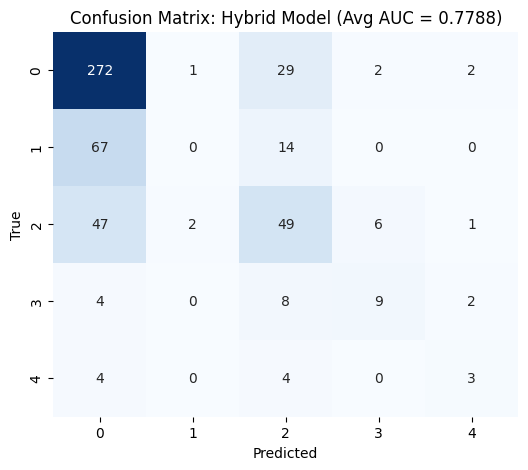

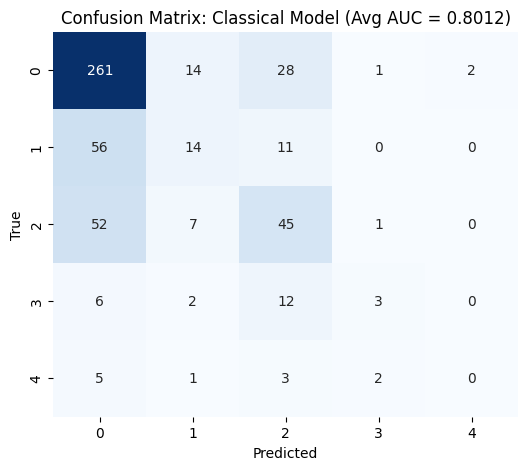

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 3

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=5)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Experiment with Seed 71:


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.7972, Training Accuracy: 13.17%, Training AUROC: 0.5243
Validation Loss: 1.5369, Validation Accuracy: 34.15%, Validation AUROC: 0.4954
Epoch [2/100]
Training Loss: 1.2771, Training Accuracy: 52.37%, Training AUROC: 0.5544
Validation Loss: 1.1666, Validation Accuracy: 58.13%, Validation AUROC: 0.5559
Epoch [3/100]
Training Loss: 1.1283, Training Accuracy: 58.23%, Training AUROC: 0.5869
Validation Loss: 1.1301, Validation Accuracy: 58.13%, Validation AUROC: 0.5800
Epoch [4/100]
Training Loss: 1.1038, Training Accuracy: 58.13%, Training AUROC: 0.6165
Validation Loss: 1.1190, Validation Accuracy: 58.13%, Validation AUROC: 0.5957
Epoch [5/100]
Training Loss: 1.0741, Training Accuracy: 58.44%, Training AUROC: 0.6599
Validation Loss: 1.1090, Validation Accuracy: 58.13%, Validation AUROC: 0.6256
Epoch [6/100]
Training Loss: 1.0713, Training Accuracy: 58.33%, Training AUROC: 0.6853
Validation Loss: 1.0944, Validation Accuracy: 56.91%, Validation AUROC: 0.6448
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.5493, Training Accuracy: 21.91%, Training AUROC: 0.5432
Validation Loss: 1.4094, Validation Accuracy: 45.93%, Validation AUROC: 0.5601
Epoch [2/100]
Training Loss: 1.3414, Training Accuracy: 54.22%, Training AUROC: 0.5354
Validation Loss: 1.3055, Validation Accuracy: 58.94%, Validation AUROC: 0.5673
Epoch [3/100]
Training Loss: 1.2892, Training Accuracy: 58.44%, Training AUROC: 0.5515
Validation Loss: 1.2842, Validation Accuracy: 57.72%, Validation AUROC: 0.5767
Epoch [4/100]
Training Loss: 1.2690, Training Accuracy: 58.54%, Training AUROC: 0.5625
Validation Loss: 1.2682, Validation Accuracy: 58.13%, Validation AUROC: 0.5839
Epoch [5/100]
Training Loss: 1.2480, Training Accuracy: 58.44%, Training AUROC: 0.5781
Validation Loss: 1.2499, Validation Accuracy: 58.13%, Validation AUROC: 0.5894
Epoch [6/100]
Training Loss: 1.2283, Training Accuracy: 58.23%, Training AUROC: 0.5787
Validation Loss: 1.2322, Validation Accuracy: 58.13%, Validation AUROC: 0.5934
Epoc

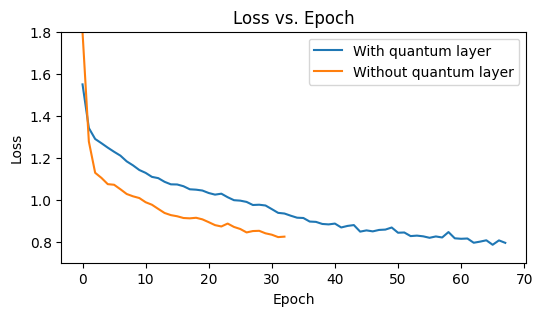

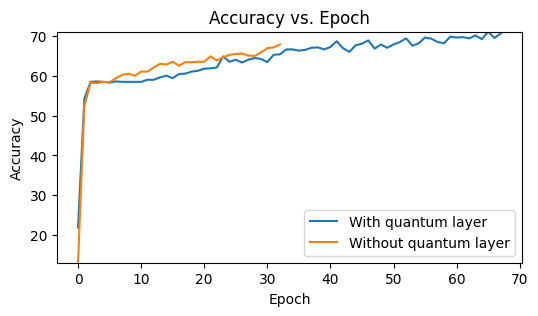

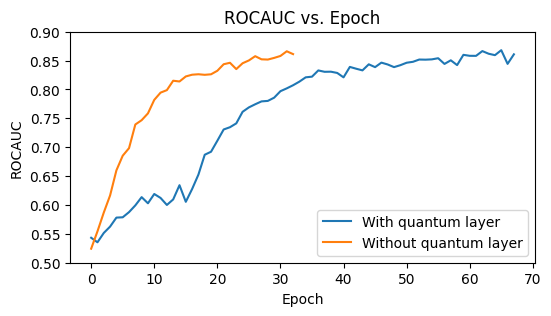

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

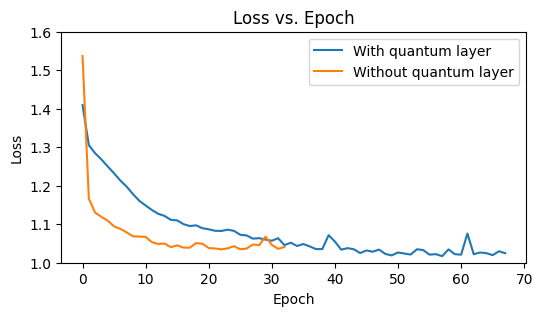

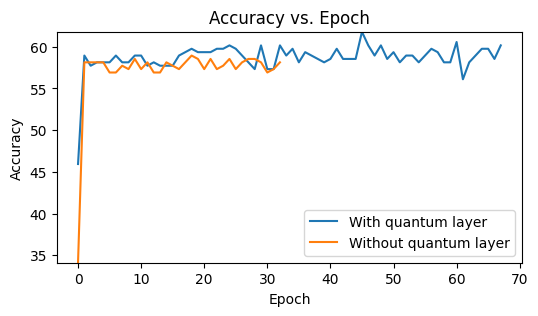

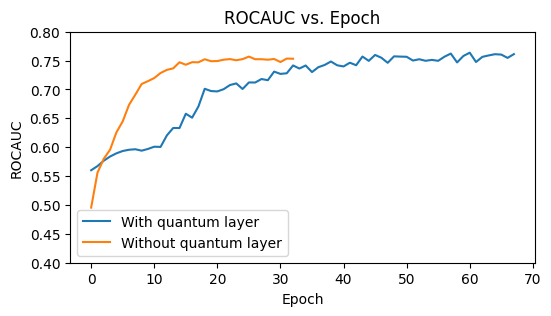

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

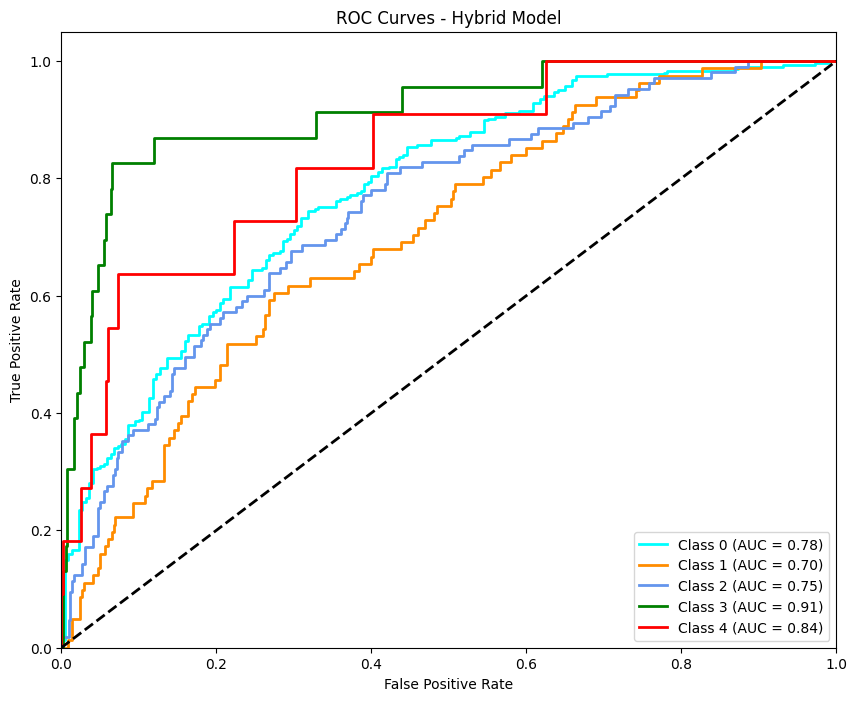

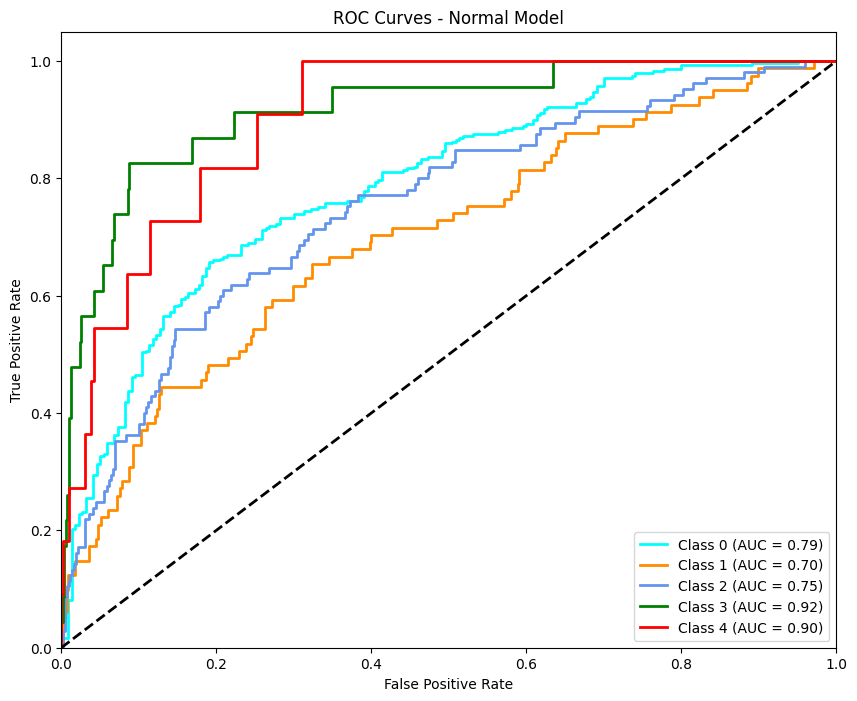


Hybrid Model Metrics:
Accuracy: 0.6236
F1 Score: 0.5651
Precision: 0.5556
Recall: 0.6236
AUROC: 0.7961

Normal Model Metrics:
Accuracy: 0.6369
F1 Score: 0.5823
Precision: 0.6574
Recall: 0.6369
AUROC: 0.8127 



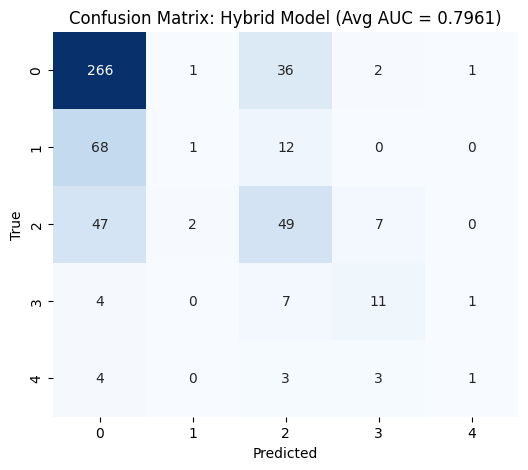

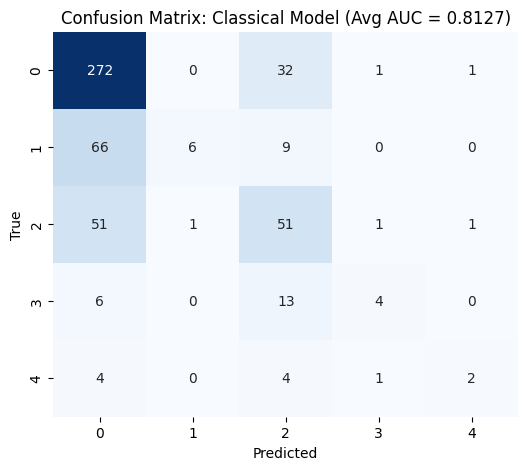

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 4

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=5)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Experiment with Seed 42:


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.6233, Training Accuracy: 24.79%, Training AUROC: 0.5222
Validation Loss: 1.4327, Validation Accuracy: 40.65%, Validation AUROC: 0.4853
Epoch [2/100]
Training Loss: 1.2324, Training Accuracy: 56.58%, Training AUROC: 0.5442
Validation Loss: 1.2036, Validation Accuracy: 56.91%, Validation AUROC: 0.5027
Epoch [3/100]
Training Loss: 1.1554, Training Accuracy: 58.13%, Training AUROC: 0.5225
Validation Loss: 1.1747, Validation Accuracy: 56.91%, Validation AUROC: 0.5257
Epoch [4/100]
Training Loss: 1.1208, Training Accuracy: 58.23%, Training AUROC: 0.5981
Validation Loss: 1.1548, Validation Accuracy: 57.32%, Validation AUROC: 0.5631
Epoch [5/100]
Training Loss: 1.0994, Training Accuracy: 58.23%, Training AUROC: 0.6288
Validation Loss: 1.1372, Validation Accuracy: 56.10%, Validation AUROC: 0.5970
Epoch [6/100]
Training Loss: 1.0769, Training Accuracy: 57.82%, Training AUROC: 0.6711
Validation Loss: 1.1308, Validation Accuracy: 54.07%, Validation AUROC: 0.6262
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.4116, Training Accuracy: 55.97%, Training AUROC: 0.5145
Validation Loss: 1.3860, Validation Accuracy: 58.13%, Validation AUROC: 0.4980
Epoch [2/100]
Training Loss: 1.3495, Training Accuracy: 58.44%, Training AUROC: 0.5428
Validation Loss: 1.3473, Validation Accuracy: 58.13%, Validation AUROC: 0.5195
Epoch [3/100]
Training Loss: 1.3220, Training Accuracy: 58.44%, Training AUROC: 0.5650
Validation Loss: 1.3315, Validation Accuracy: 58.13%, Validation AUROC: 0.5322
Epoch [4/100]
Training Loss: 1.2954, Training Accuracy: 58.44%, Training AUROC: 0.6056
Validation Loss: 1.3097, Validation Accuracy: 58.13%, Validation AUROC: 0.5763
Epoch [5/100]
Training Loss: 1.2826, Training Accuracy: 58.44%, Training AUROC: 0.6053
Validation Loss: 1.2880, Validation Accuracy: 58.13%, Validation AUROC: 0.5925
Epoch [6/100]
Training Loss: 1.2550, Training Accuracy: 58.44%, Training AUROC: 0.6371
Validation Loss: 1.2695, Validation Accuracy: 58.13%, Validation AUROC: 0.6313
Epoc

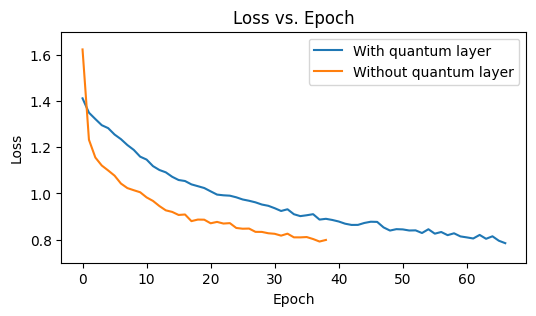

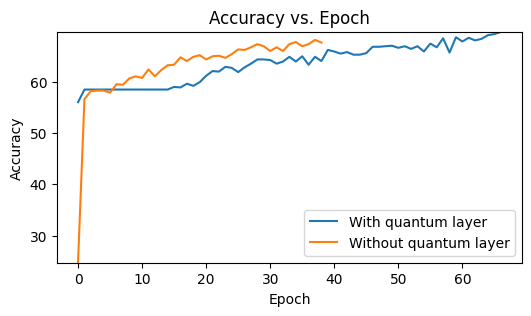

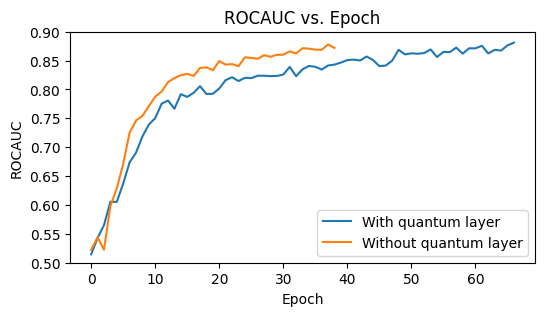

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

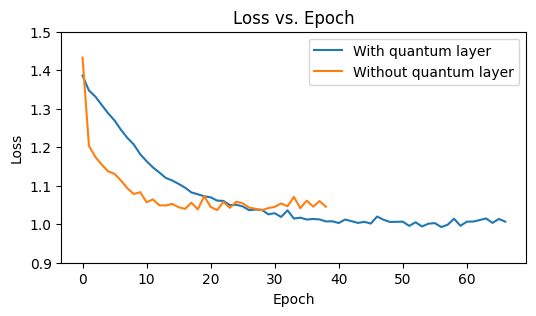

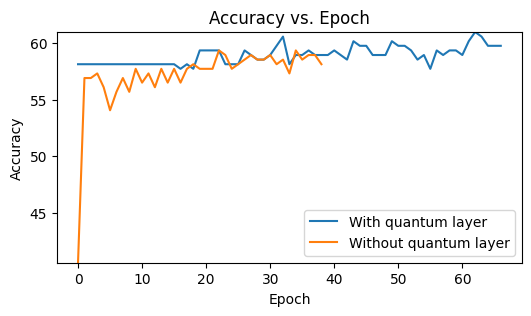

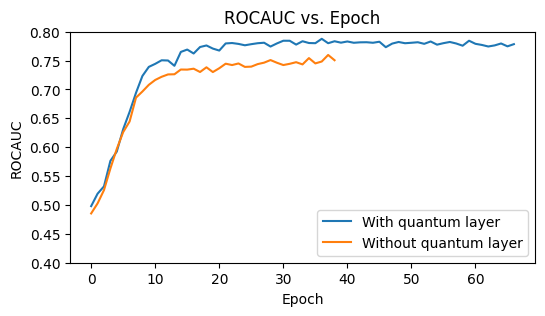

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


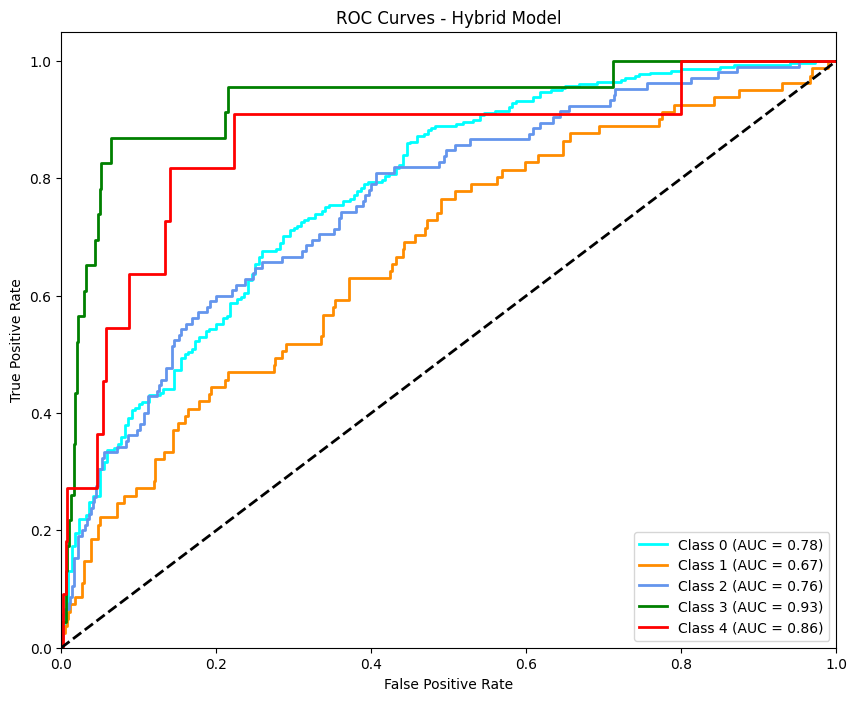

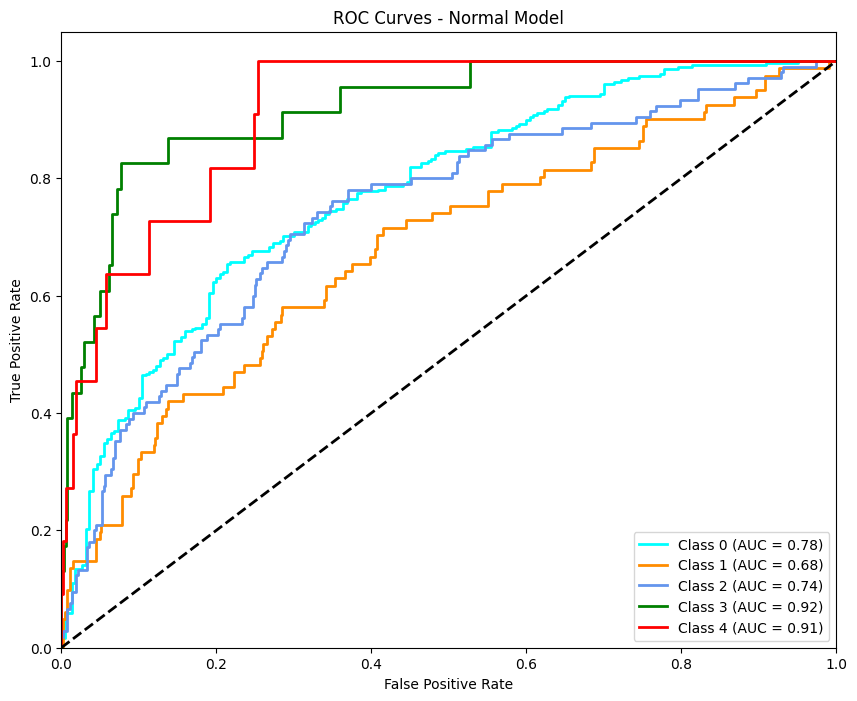


Hybrid Model Metrics:
Accuracy: 0.6426
F1 Score: 0.5839
Precision: 0.6344
Recall: 0.6426
AUROC: 0.8006

Normal Model Metrics:
Accuracy: 0.6407
F1 Score: 0.5887
Precision: 0.6260
Recall: 0.6407
AUROC: 0.8065 



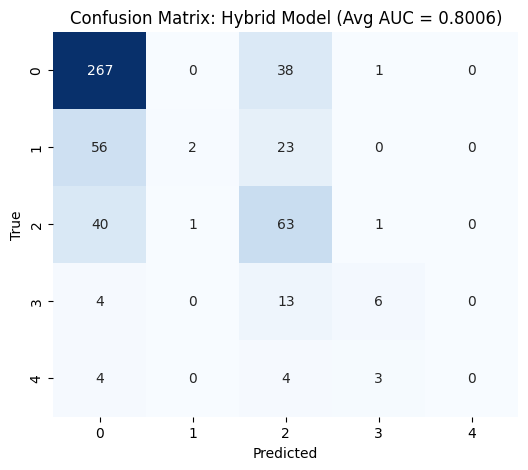

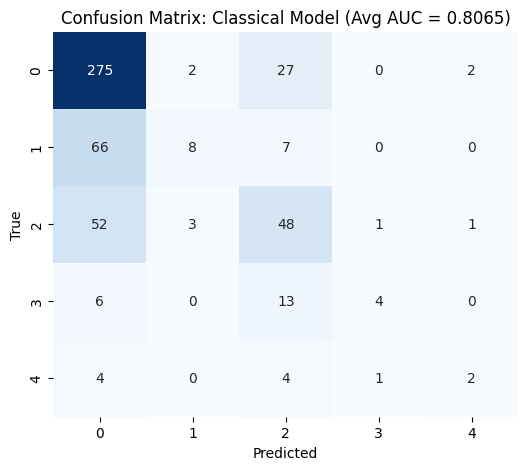

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 5

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model_normal = NormalModel(freeze=True, num_classes=5)
model_hybrid = QuantumHybridModel(q_depth=4, freeze=True, num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Experiment with Seed 49:


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 221MB/s]


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.4357, Training Accuracy: 38.07%, Training AUROC: 0.5271
Validation Loss: 1.3105, Validation Accuracy: 54.88%, Validation AUROC: 0.4765
Epoch [2/100]
Training Loss: 1.1965, Training Accuracy: 57.41%, Training AUROC: 0.5507
Validation Loss: 1.1814, Validation Accuracy: 58.13%, Validation AUROC: 0.5259
Epoch [3/100]
Training Loss: 1.1428, Training Accuracy: 58.13%, Training AUROC: 0.6023
Validation Loss: 1.1558, Validation Accuracy: 56.91%, Validation AUROC: 0.5591
Epoch [4/100]
Training Loss: 1.1227, Training Accuracy: 58.13%, Training AUROC: 0.6156
Validation Loss: 1.1407, Validation Accuracy: 55.28%, Validation AUROC: 0.5920
Epoch [5/100]
Training Loss: 1.0918, Training Accuracy: 57.82%, Training AUROC: 0.6602
Validation Loss: 1.1182, Validation Accuracy: 58.13%, Validation AUROC: 0.6265
Epoch [6/100]
Training Loss: 1.0665, Training Accuracy: 58.23%, Training AUROC: 0.7050
Validation Loss: 1.0936, Validation Accuracy: 54.47%, Validation AUROC: 0.6557
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.5171, Training Accuracy: 15.74%, Training AUROC: 0.5137
Validation Loss: 1.4937, Validation Accuracy: 17.07%, Validation AUROC: 0.5353
Epoch [2/100]
Training Loss: 1.4968, Training Accuracy: 18.72%, Training AUROC: 0.5093
Validation Loss: 1.4769, Validation Accuracy: 20.33%, Validation AUROC: 0.5246
Epoch [3/100]
Training Loss: 1.4793, Training Accuracy: 18.42%, Training AUROC: 0.5335
Validation Loss: 1.4569, Validation Accuracy: 20.33%, Validation AUROC: 0.5325
Epoch [4/100]
Training Loss: 1.4604, Training Accuracy: 22.43%, Training AUROC: 0.5524
Validation Loss: 1.4383, Validation Accuracy: 25.20%, Validation AUROC: 0.5326
Epoch [5/100]
Training Loss: 1.4385, Training Accuracy: 31.79%, Training AUROC: 0.5504
Validation Loss: 1.4192, Validation Accuracy: 36.59%, Validation AUROC: 0.5315
Epoch [6/100]
Training Loss: 1.4119, Training Accuracy: 37.55%, Training AUROC: 0.5667
Validation Loss: 1.3962, Validation Accuracy: 43.90%, Validation AUROC: 0.5287
Epoc

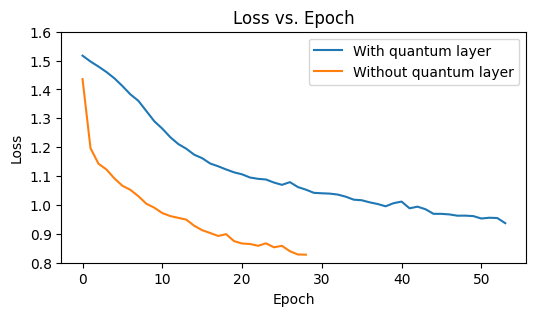

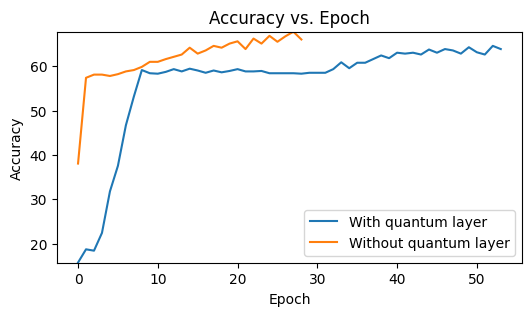

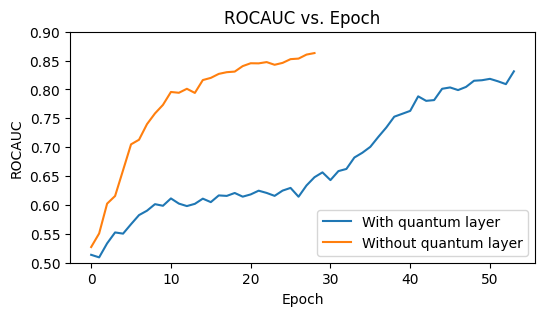

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

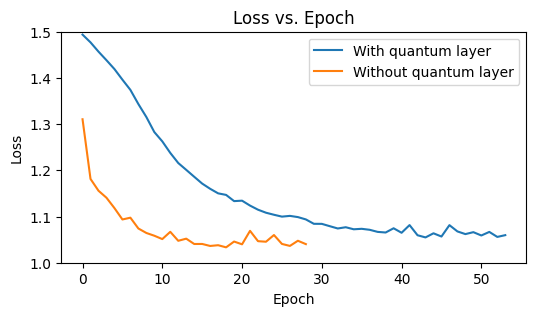

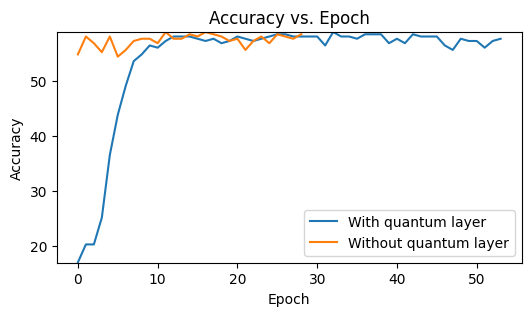

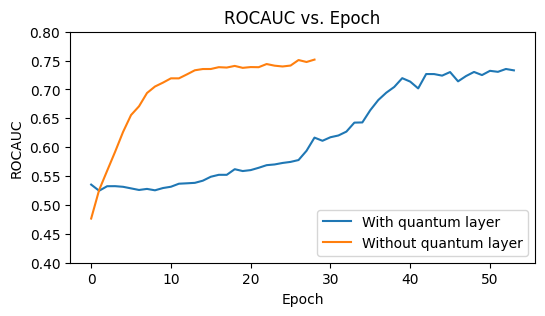

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/Resnet-18-MESSIDOR_models/normal_model_82.pth")
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/Resnet-18-MESSIDOR_models/quantum_hybrid_model_82.pth")

<ipython-input-23-50c25cca7f42>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/Resnet-18-MES

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


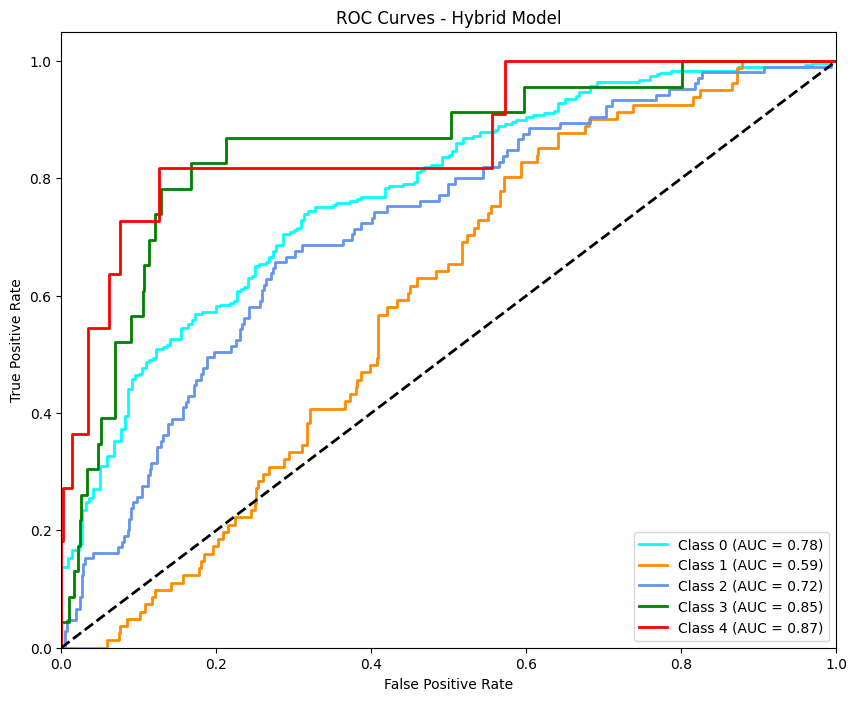

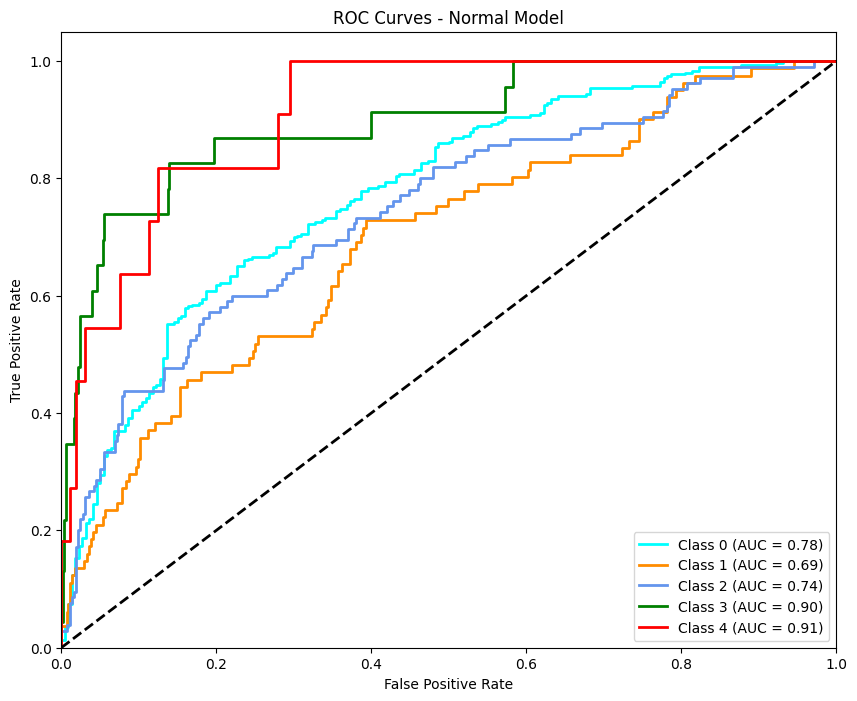


Hybrid Model Metrics:
Accuracy: 0.5951
F1 Score: 0.5257
Precision: 0.4827
Recall: 0.5951
AUROC: 0.7602

Normal Model Metrics:
Accuracy: 0.6483
F1 Score: 0.5763
Precision: 0.6610
Recall: 0.6483
AUROC: 0.8049 



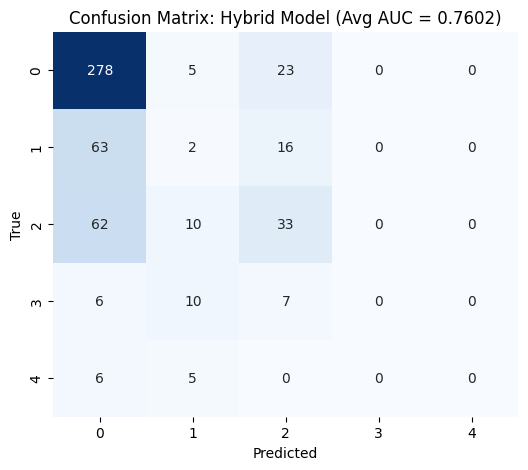

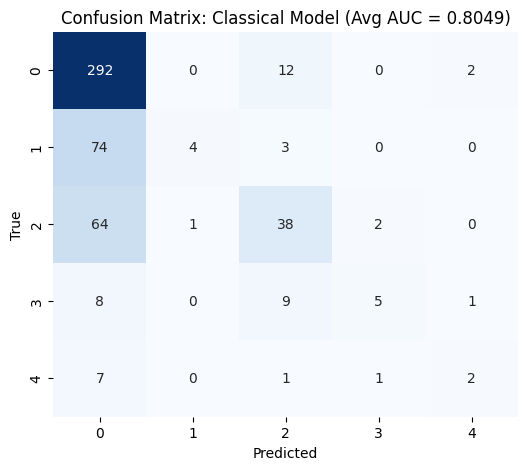

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)